### Visualize feature decoding when its split by correct/incorrect trials

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils

import os
import pandas as pd
import matplotlib

In [2]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
EVENT = "FeedbackOnset"

# output dir that was specified in the decode_features_with_pseudo.py
OUTPUT_DIR = "/data/patrick_scratch/pseudo"

SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions.pickle"

FEATURE_DIMS = ["Color", "Shape", "Pattern"]

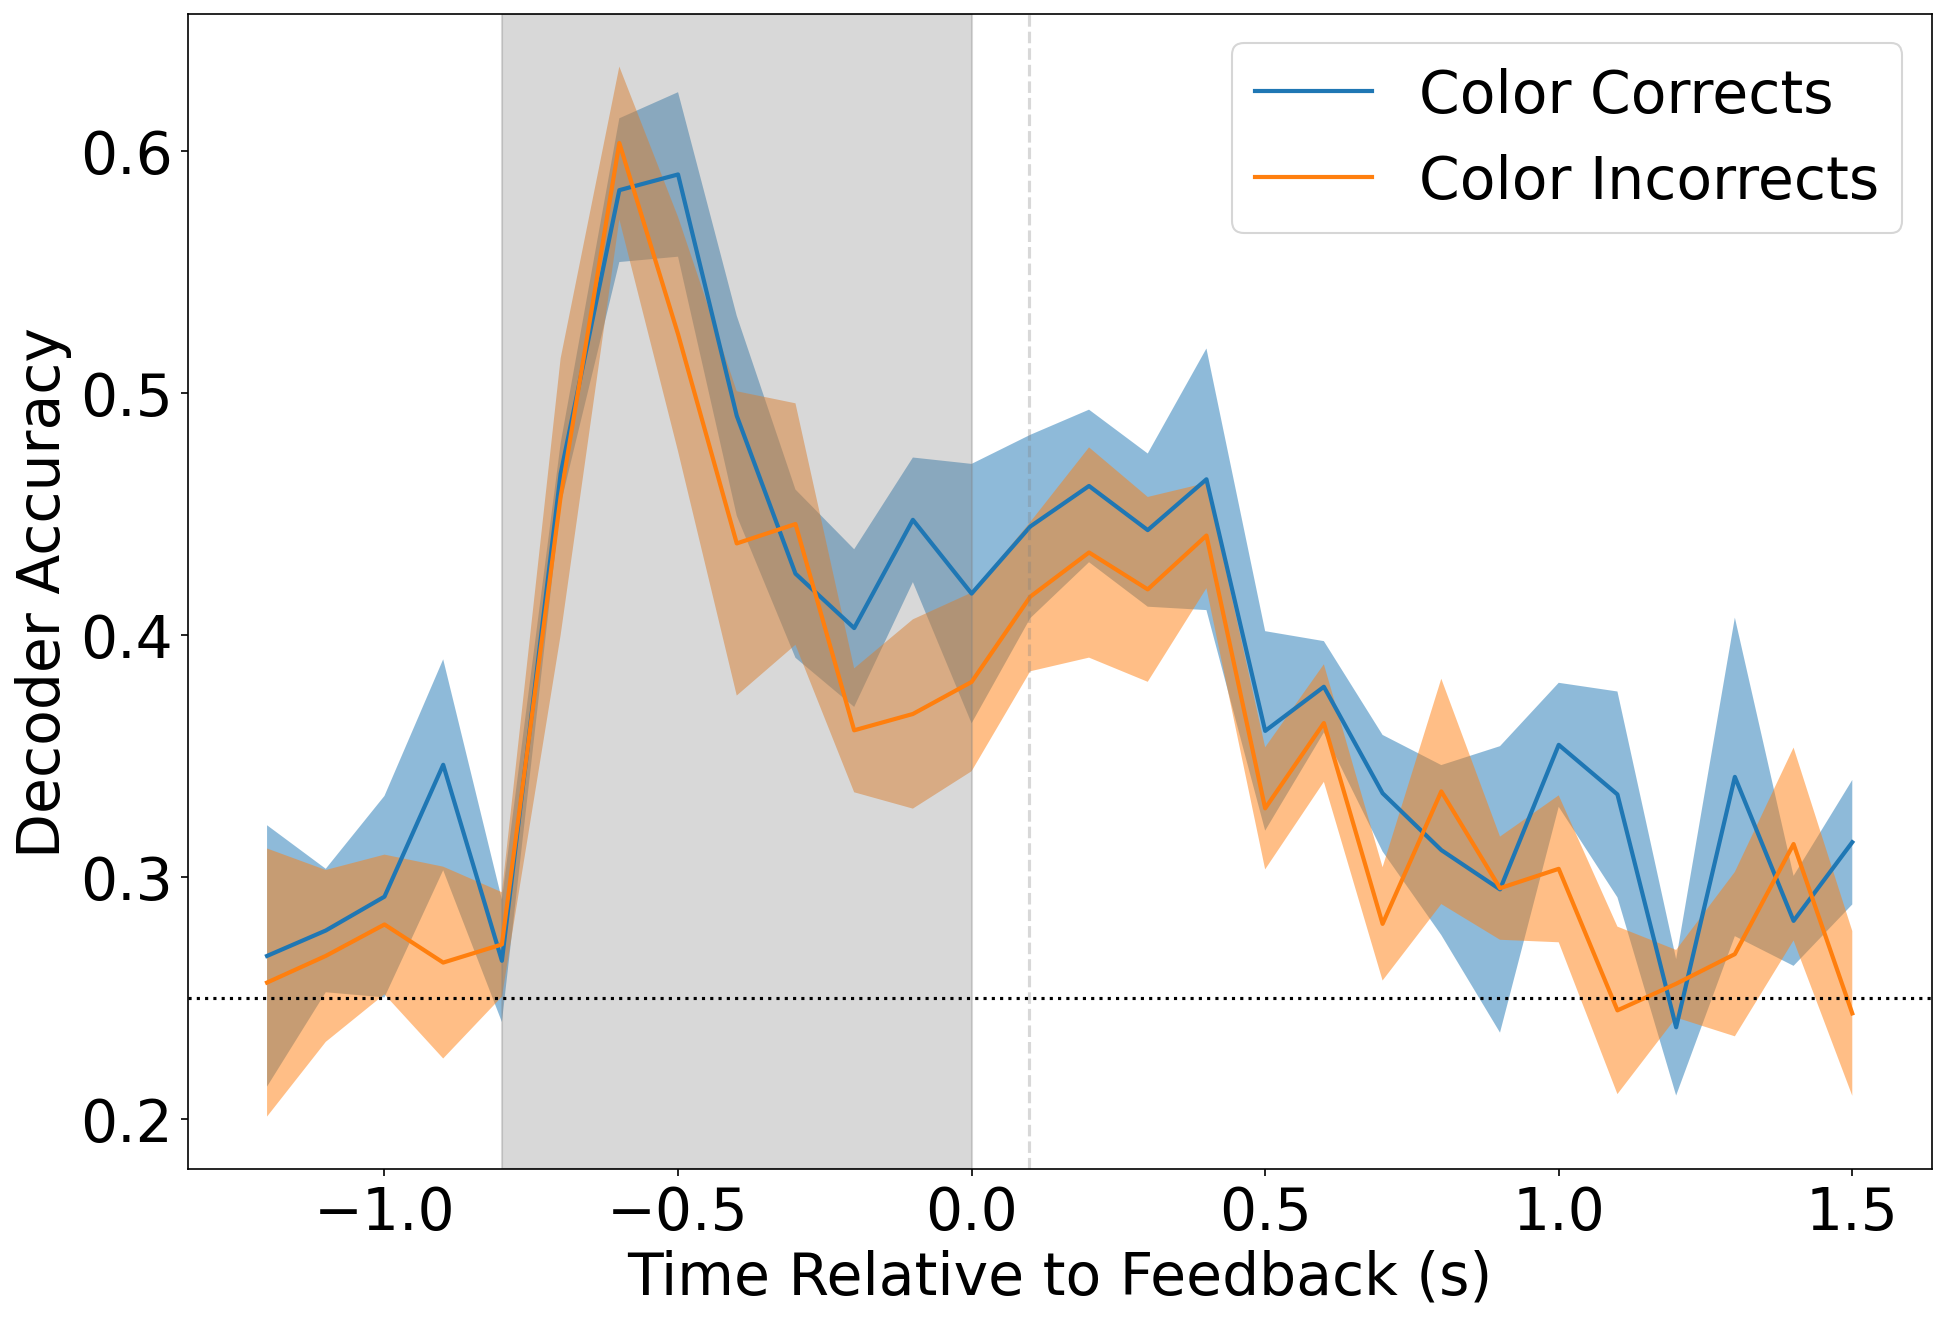

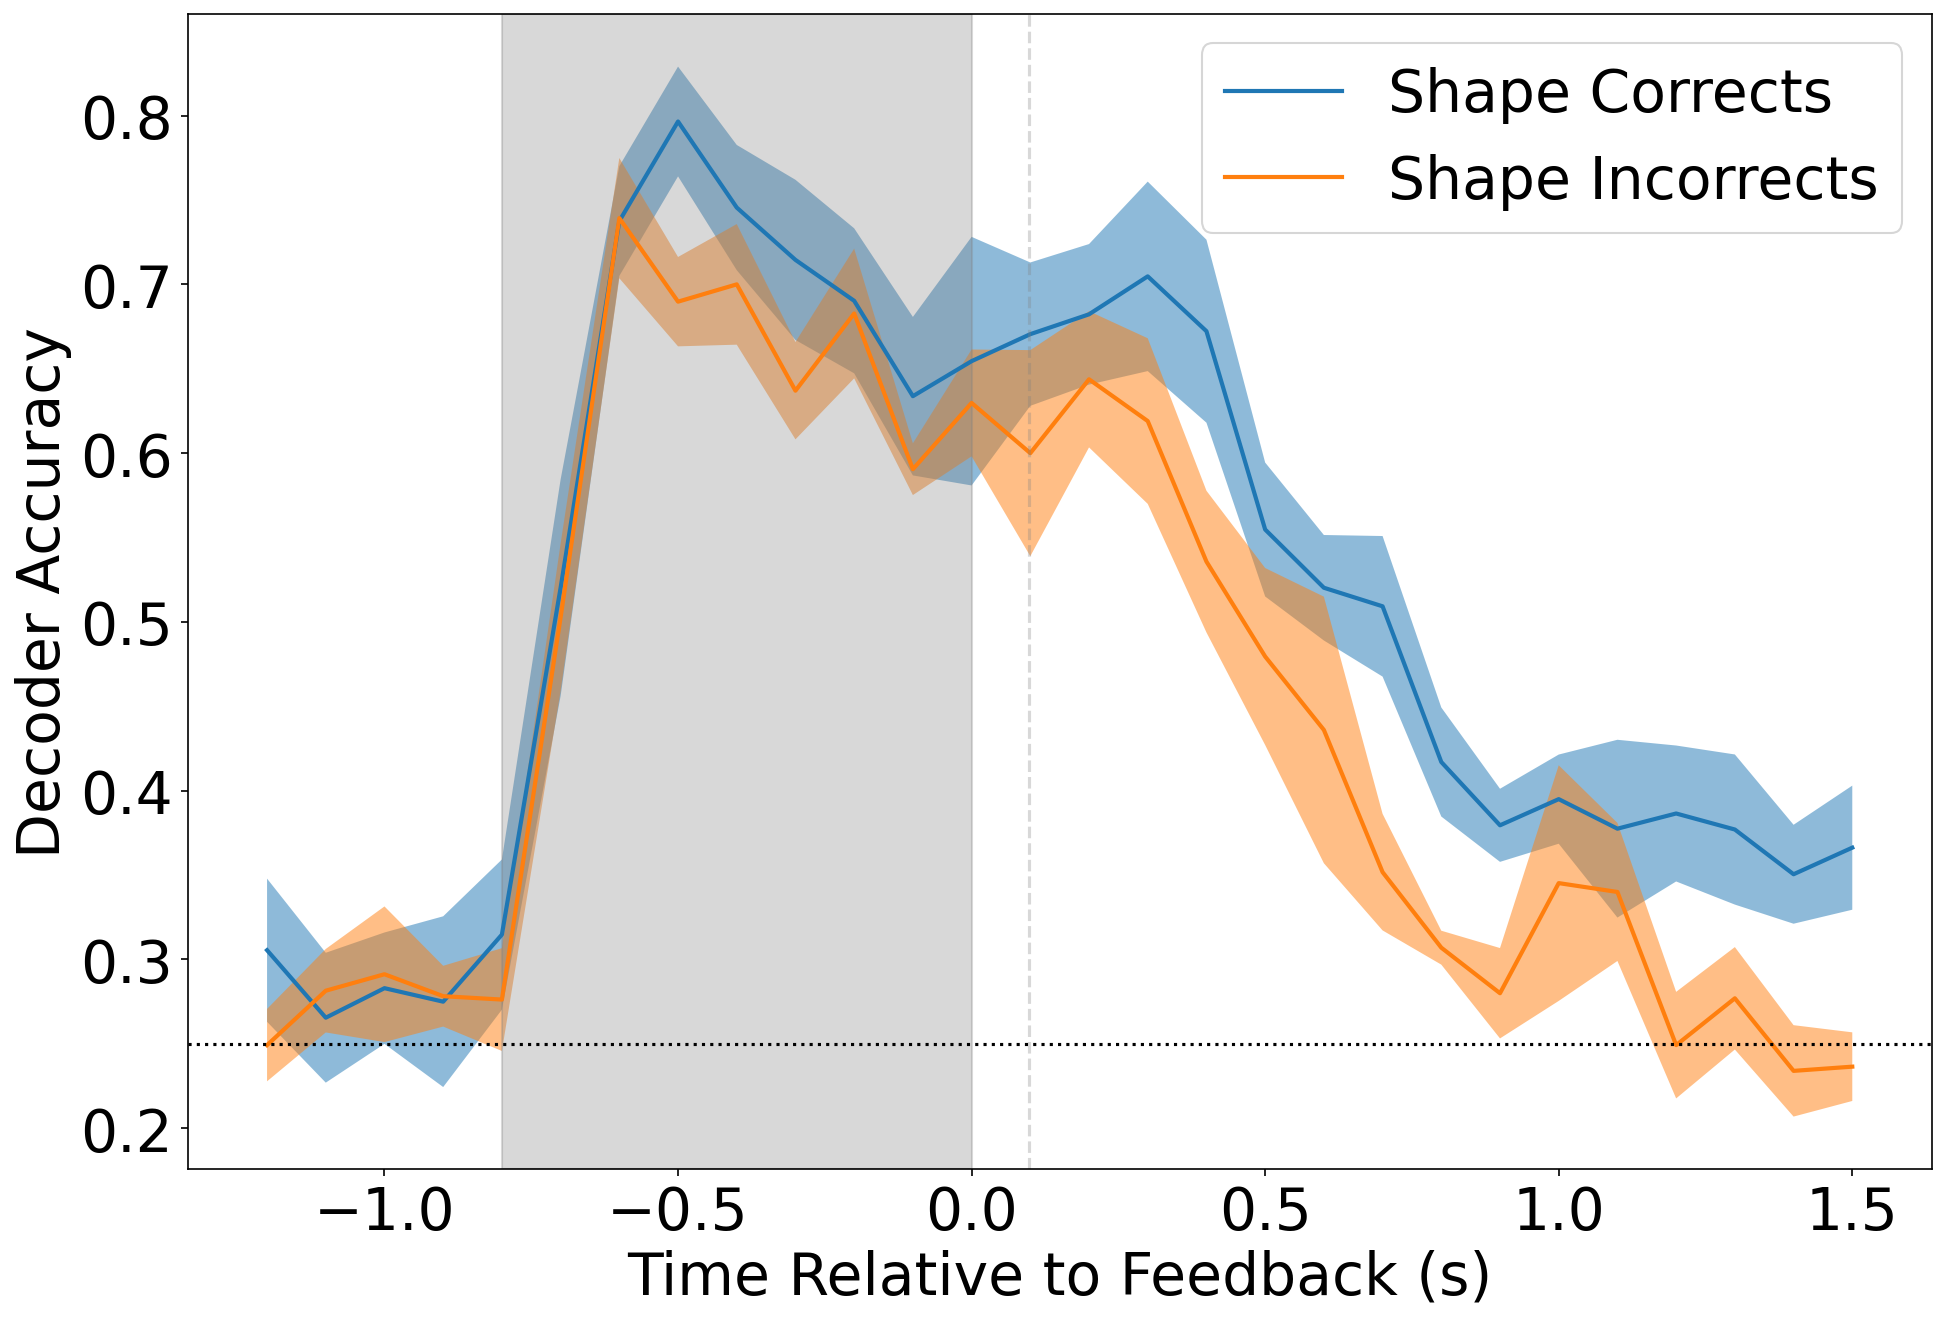

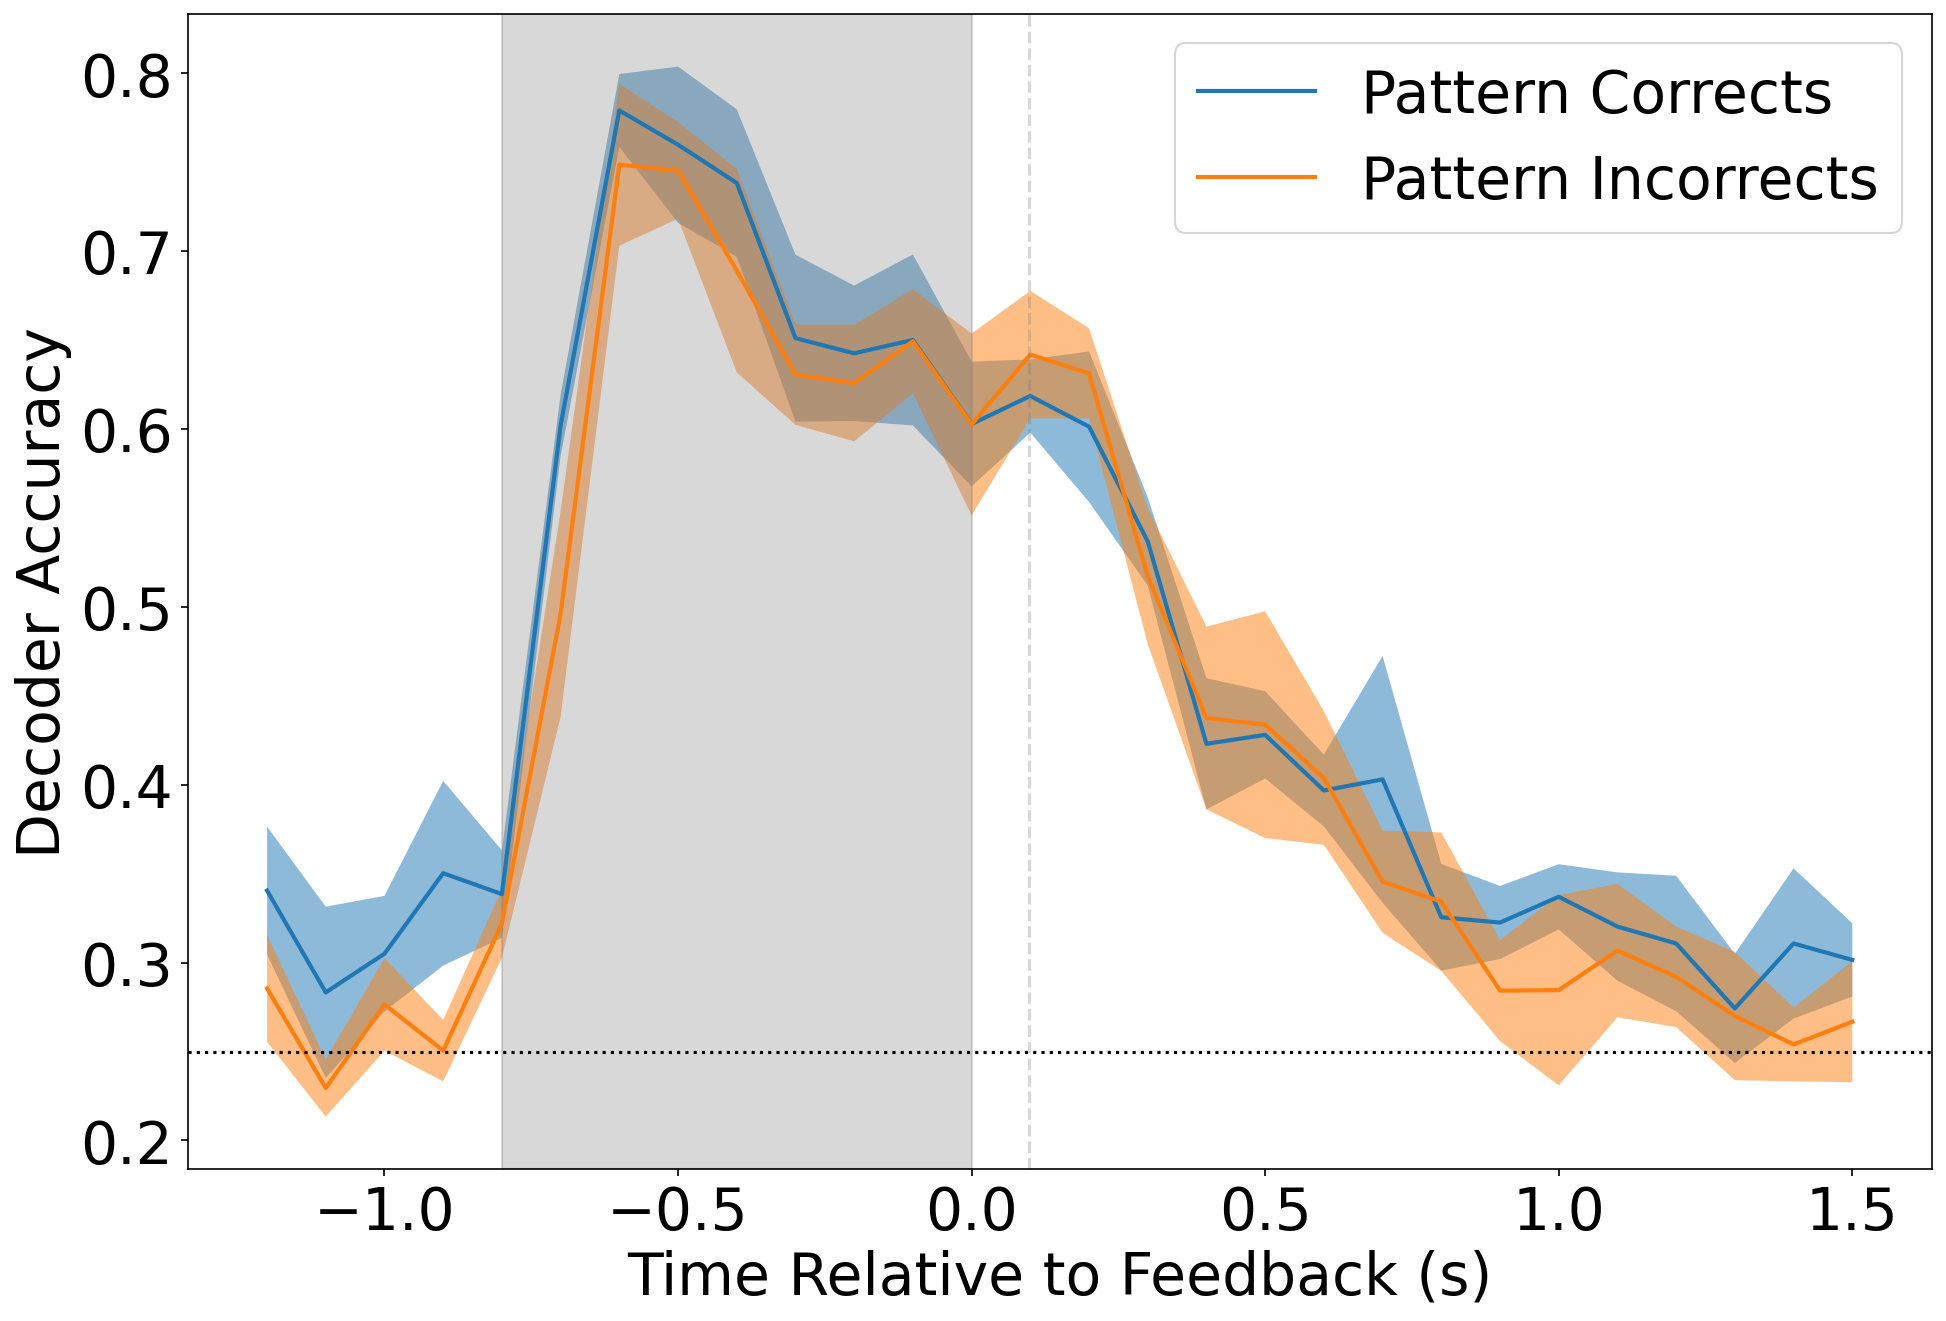

In [3]:
matplotlib.rcParams.update({'font.size': 28})
for feature_dim in FEATURE_DIMS:
    fig, ax = plt.subplots(dpi=150, figsize=(15, 10))

    cor_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_Correct_test_accs.npy"))
    inc_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_Incorrect_test_accs.npy"))

    # plots the mean and standard deviation of decoding accuracy across splits, by time. 
    visualization_utils.visualize_accuracy_across_time_bins(
        cor_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"{feature_dim} Corrects",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        inc_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"{feature_dim} Incorrects",
        right_align=True, 
    )
    ax.legend()
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")

### Look at weights

In [7]:
valid_sess = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(valid_sess)
positions = positions[positions.manual_structure != "unknown"]

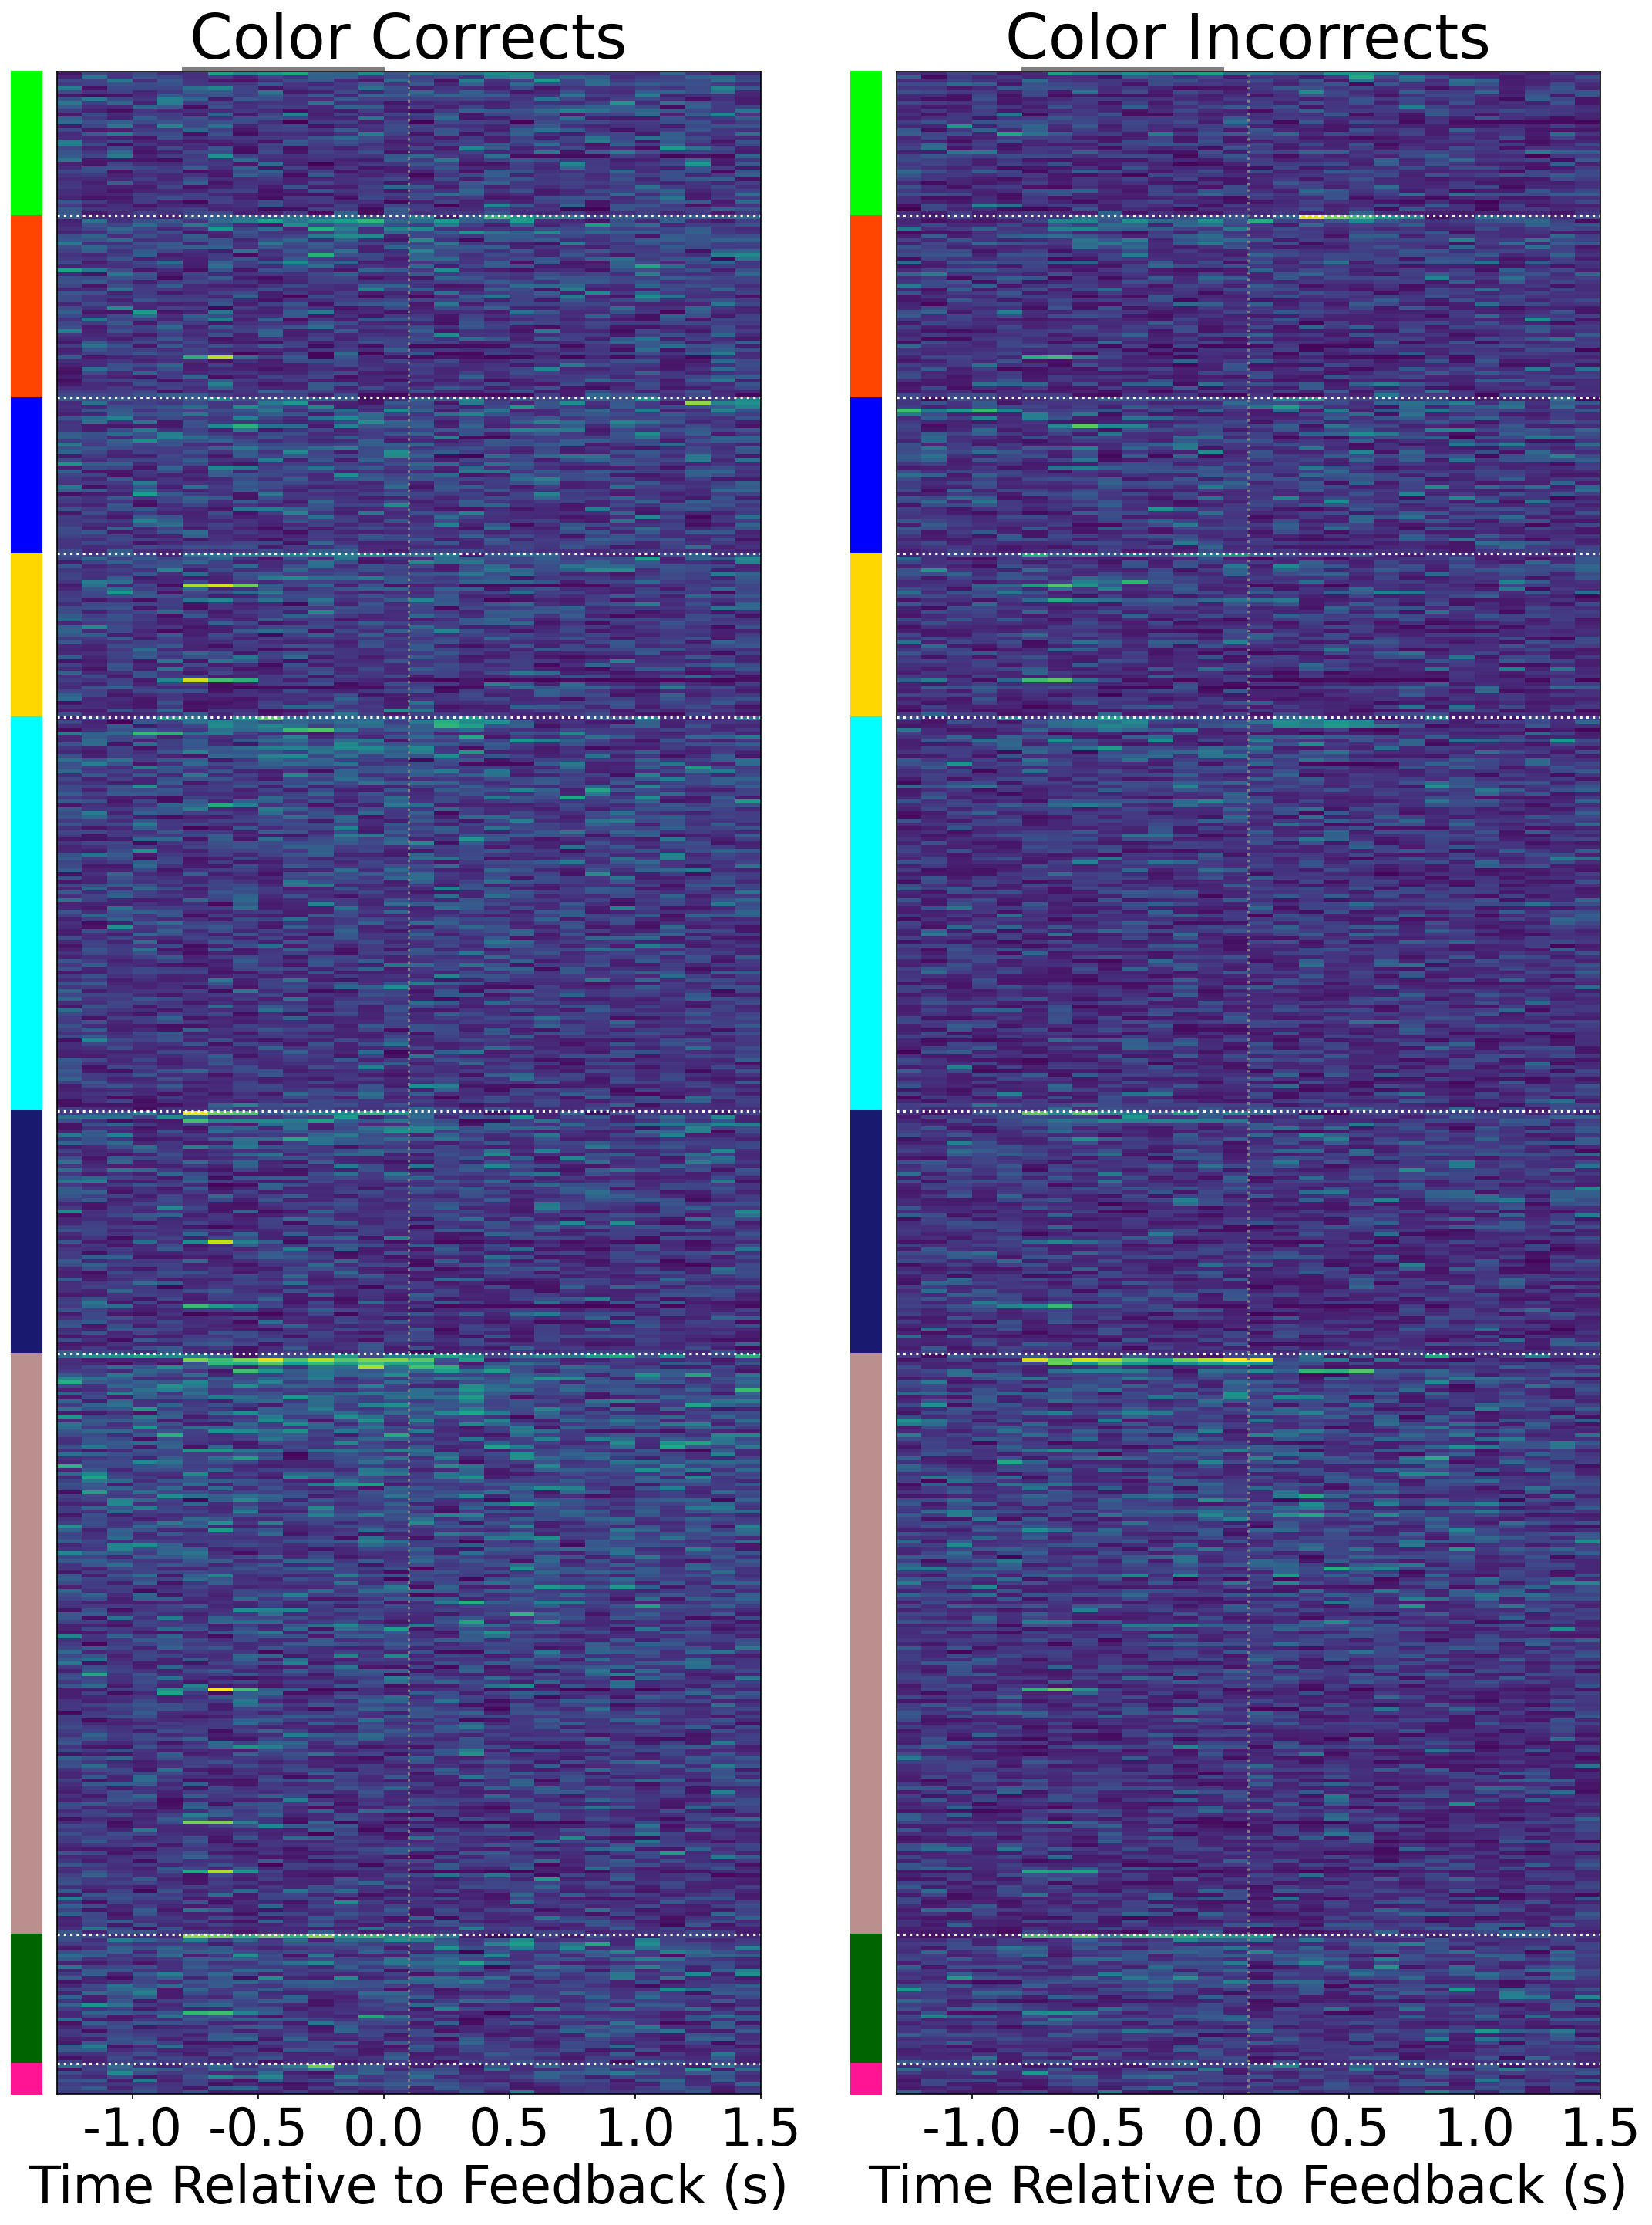

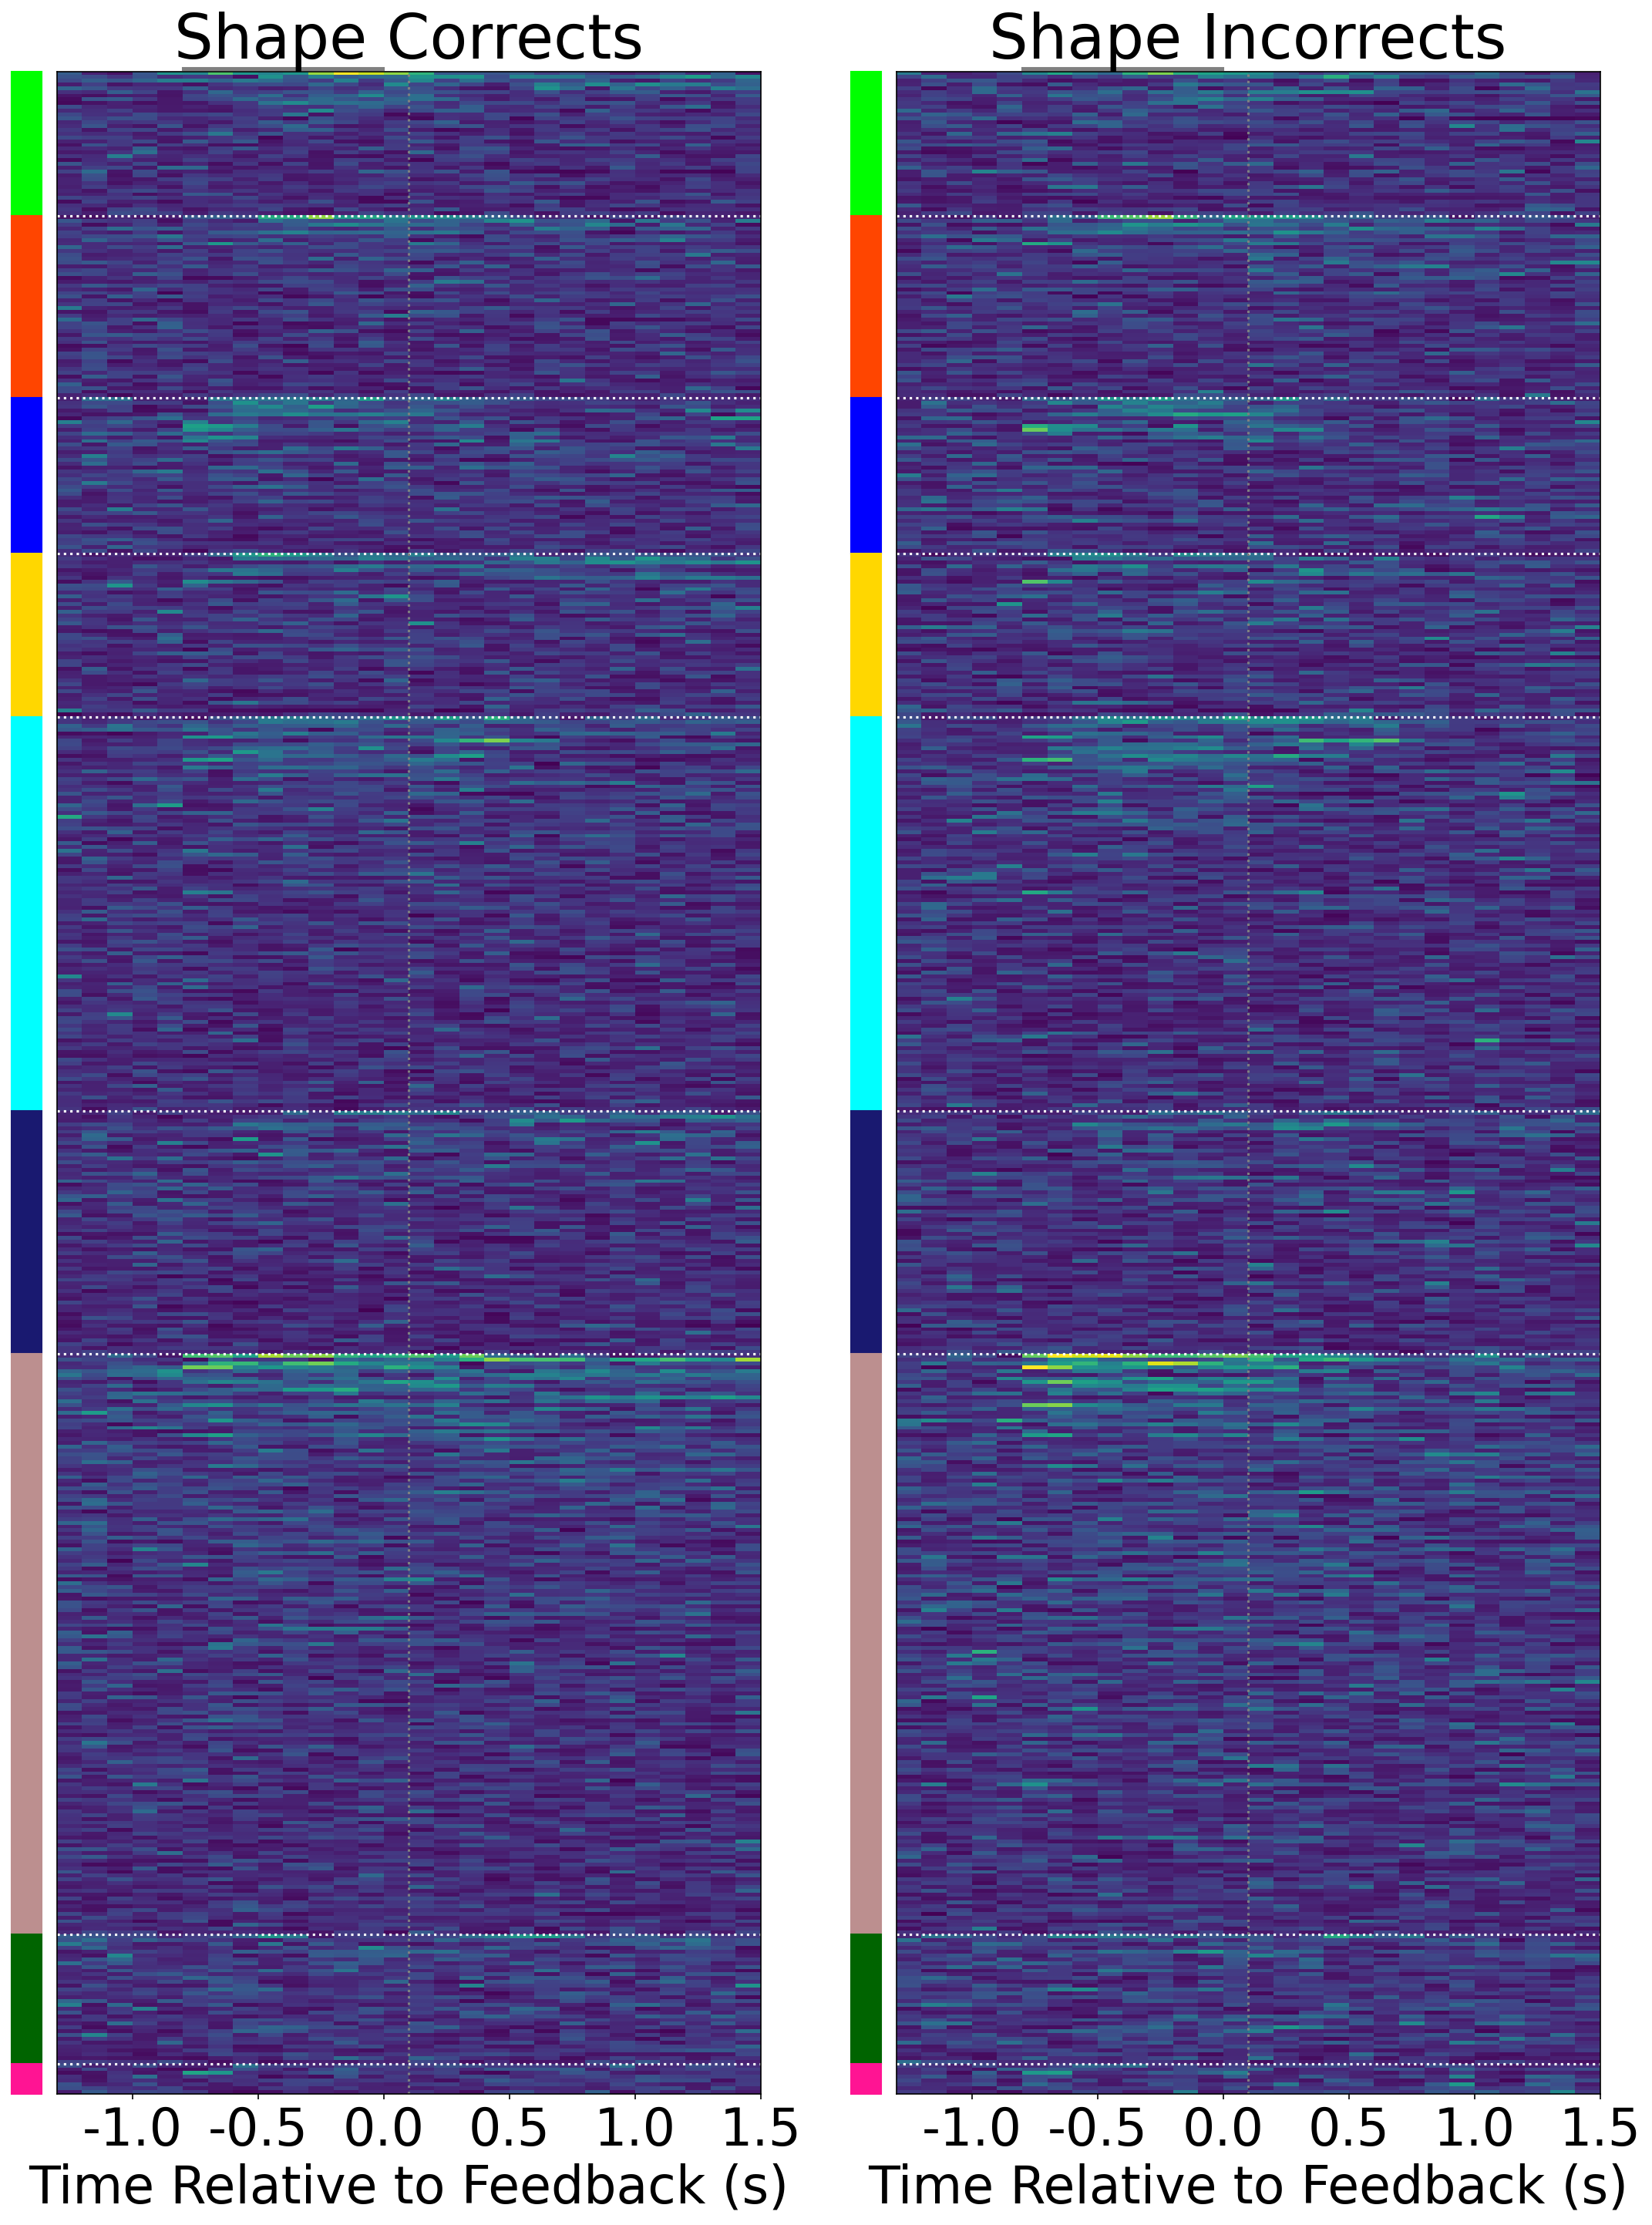

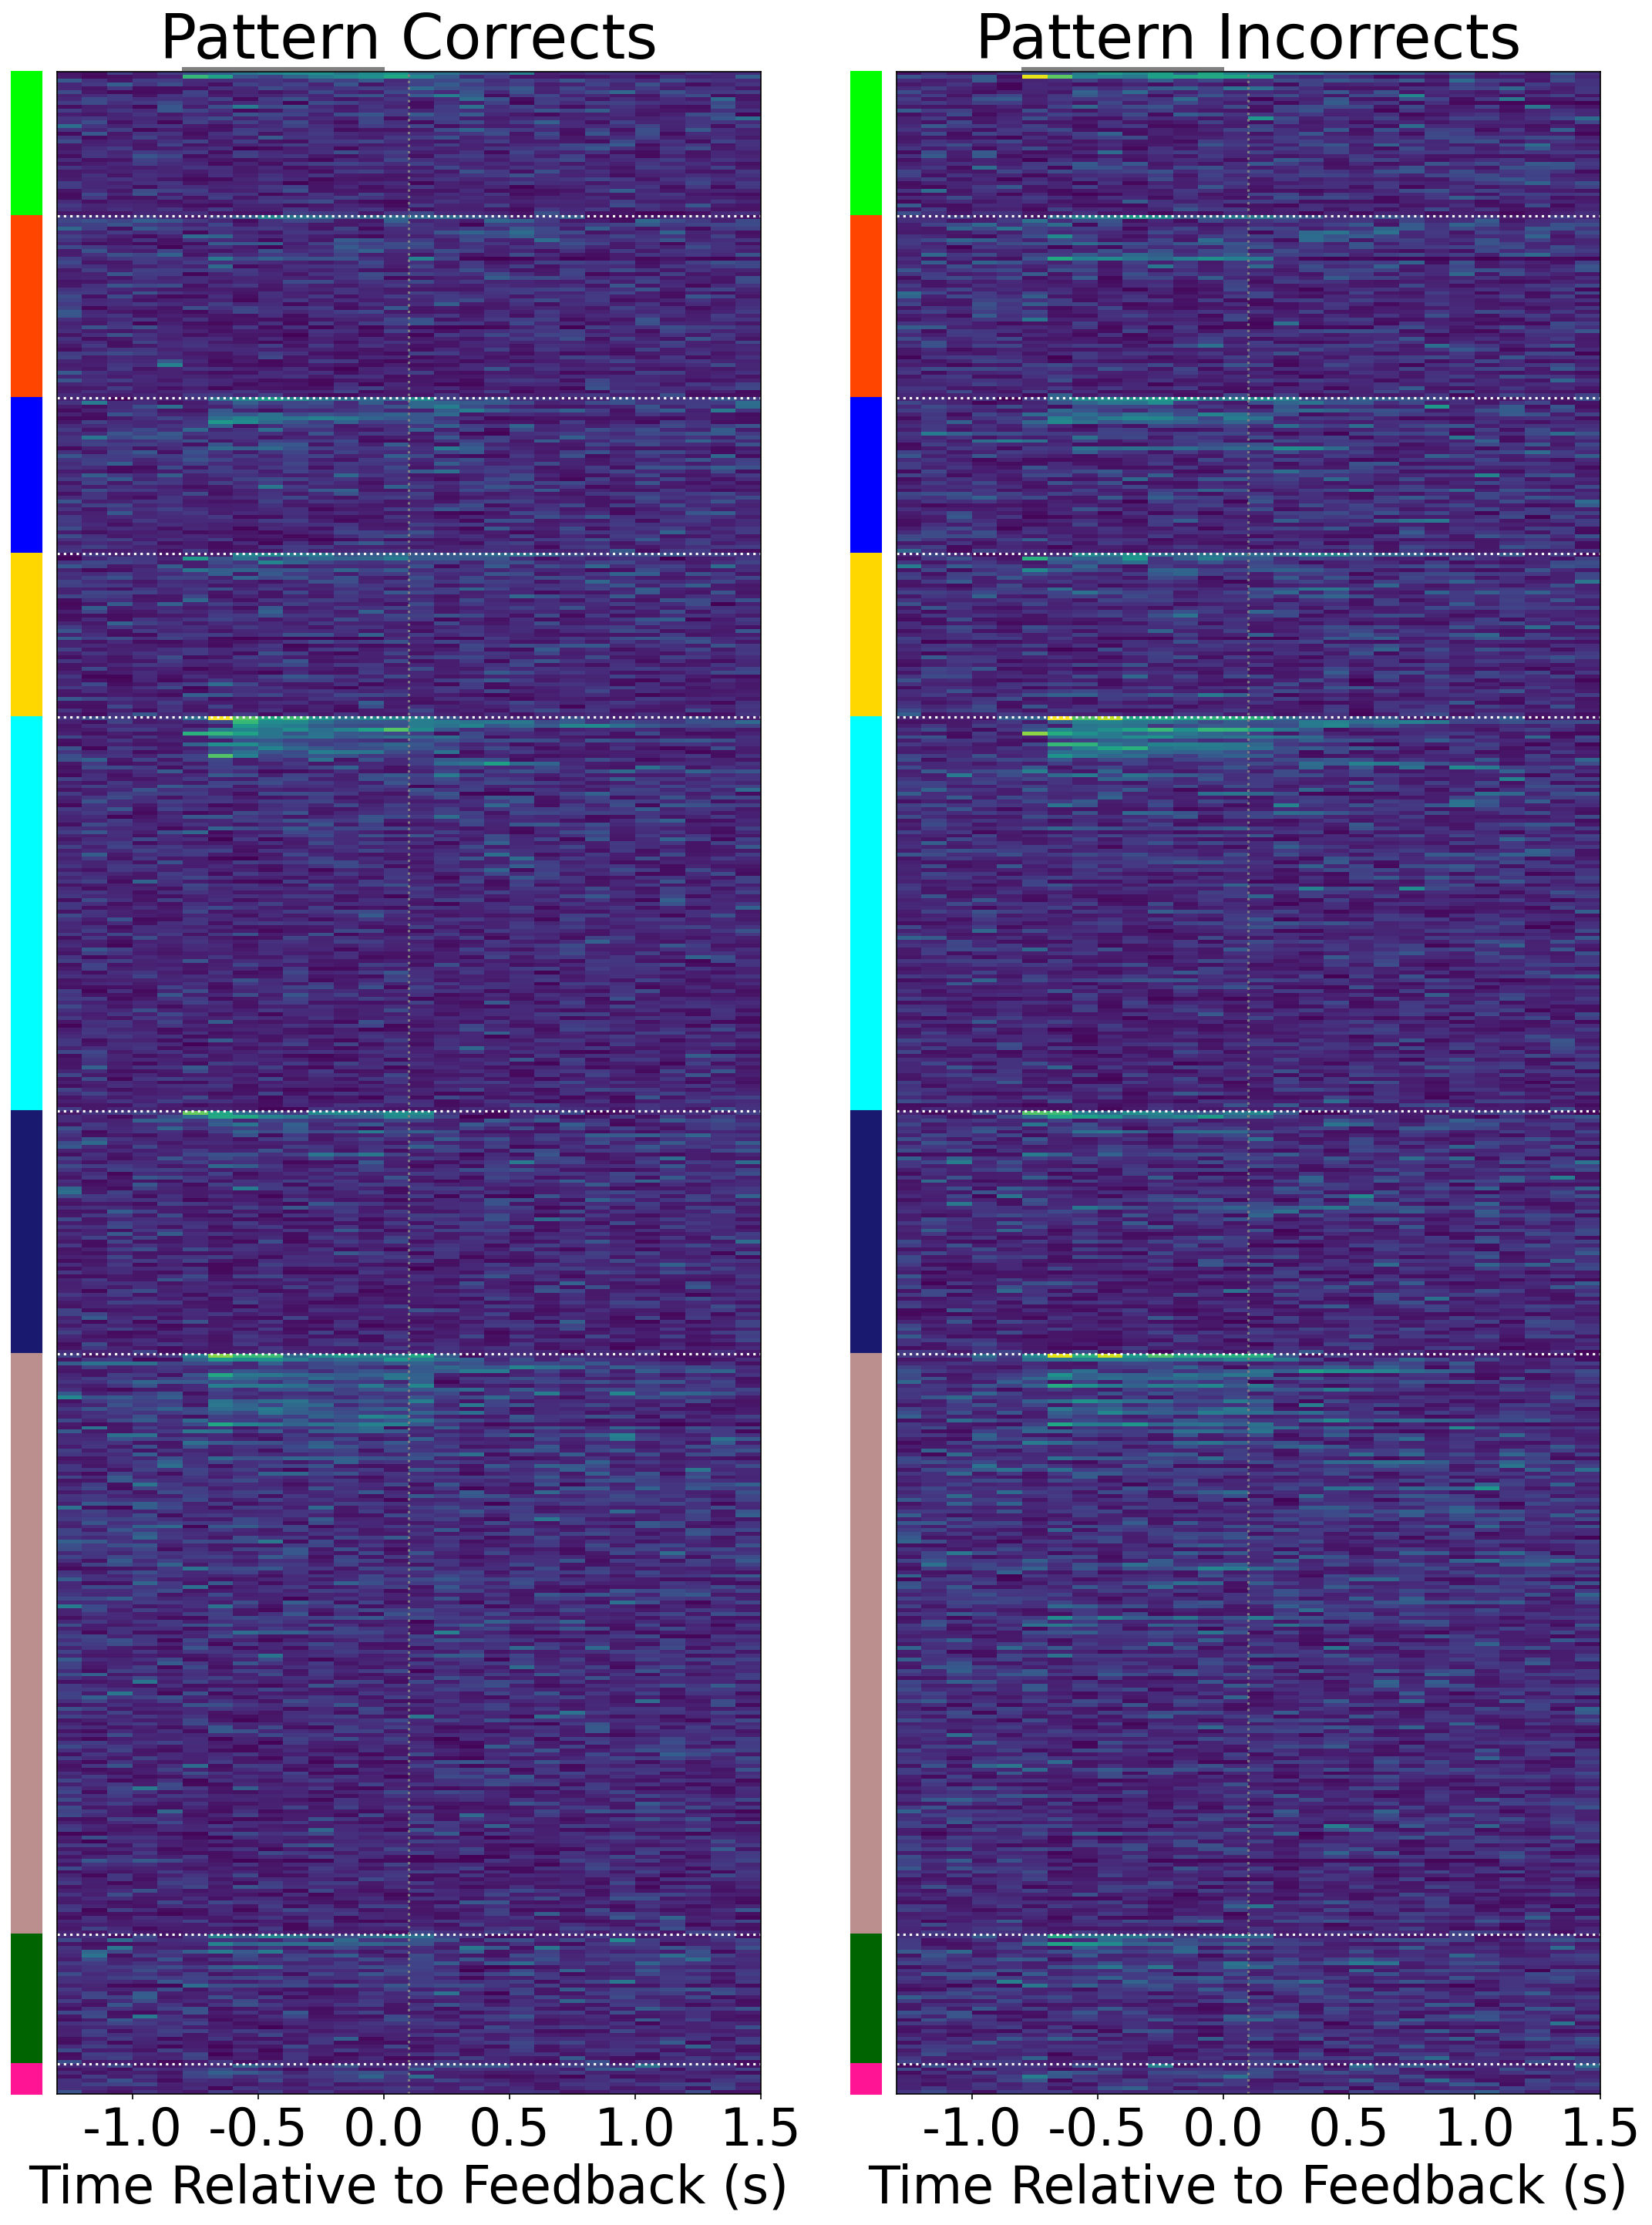

In [8]:
matplotlib.rcParams.update({'font.size': 32})
for i, feature_dim in enumerate(FEATURE_DIMS):
    cor_models = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_Correct_models.npy"), allow_pickle=True)
    inc_models = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_Incorrect_models.npy"), allow_pickle=True)

    # evaluate weights by time. Pass in number of neurons and number of classes
    cor_weights = classifier_utils.evaluate_model_weights_by_time_bins(cor_models, num_neurons=1117, num_classes=4)
    inc_weights = classifier_utils.evaluate_model_weights_by_time_bins(inc_models, num_neurons=1117, num_classes=4)

    norm_cor_weights = cor_weights / np.sum(cor_weights, axis=0)
    norm_inc_weights = inc_weights / np.sum(inc_weights, axis=0)

    means = np.mean(norm_cor_weights, axis=1)
    ordering_df = pd.DataFrame({'np_idx': np.arange(len(means)), 'weight': means})
    fig, axs = plt.subplots(1, 2, figsize=(15, 20), dpi=150, sharex=True)
    visualization_utils.visualize_weights(
        positions, 
        norm_cor_weights, 
        "manual_structure", 
        name_to_color=visualization_utils.REGION_TO_COLOR, 
        add_region=True, 
        mean_weights_df=ordering_df,
        ax=axs[0]
    )
    axs[0].set_title(f"{feature_dim} Corrects")
    visualization_utils.visualize_weights(
        positions, 
        norm_inc_weights, 
        "manual_structure", 
        name_to_color=visualization_utils.REGION_TO_COLOR, 
        add_region=True, 
        mean_weights_df=ordering_df,
        ax=axs[1]
    )
    axs[1].set_title(f"{feature_dim} Incorrects")

# plt.xlabel("Time Relative to Feedback (s)")
    fig.tight_layout()